In [1]:
import torch
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
from torch import nn
from torch import distributions
from tqdm.autonotebook import tqdm
from torch import optim
import numpy as np
import time

/Users/priyankashrestha/Documents/stanford/research/engelhardt_research/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def make_data(D=3, N=50):
  X = Normal(0, 1.0).sample((N,))*10
  Y = torch.zeros((D, N))
  for i in range(D):
    Y[i] = (i+1)*torch.sin(2**(i-1)*X) + Normal(0, 0.1).sample((N,))
  return X,Y

In [4]:
X, Y = make_data(D=3, N=400)

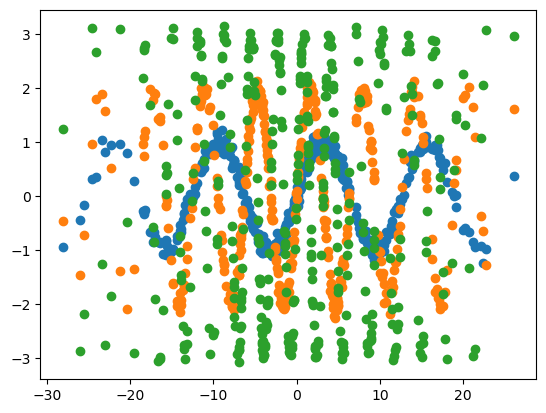

In [5]:
for i in range(3):
  plt.scatter(X, Y[i])

In [6]:
X = X[:, None]

In [7]:
L = 3
M = 300
idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, M=M, jitter=1e-1, K=5)
gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
gp.mu = nn.Parameter(torch.randn((L, M)))
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)

/var/folders/dv/w3pzlt_11hdcpw6gskd45b_80000gn/T/ipykernel_24778/3573637016.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


In [8]:
model = GaussianLikelihood(gp=gp, noise=0.1)
model.to(device)

GaussianLikelihood(
  (gp): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [9]:
X_train = X.to(device)
Y_train = Y.to(device)

In [10]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []

    means = []
    scales = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)

        logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [11]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

In [12]:
model.to(device)
losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=2000, E=10)

  0%|          | 0/2000 [00:00<?, ?it/s]

distances: torch.Size([400, 300])
Indexes shape:  torch.Size([400, 5])
Kxz: torch.Size([1200, 300])
kzz_inv: torch.Size([1200, 5, 5])
indexes: torch.Size([400, 5])
Expanded shape torch.Size([1200, 5])
distances: torch.Size([400, 300])
Indexes shape:  torch.Size([400, 5])
Kxz: torch.Size([1200, 300])
kzz_inv: torch.Size([1200, 5, 5])
indexes: torch.Size([400, 5])
Expanded shape torch.Size([1200, 5])
distances: torch.Size([400, 300])
Indexes shape:  torch.Size([400, 5])
Kxz: torch.Size([1200, 300])
kzz_inv: torch.Size([1200, 5, 5])
indexes: torch.Size([400, 5])
Expanded shape torch.Size([1200, 5])
distances: torch.Size([400, 300])
Indexes shape:  torch.Size([400, 5])
Kxz: torch.Size([1200, 300])
kzz_inv: torch.Size([1200, 5, 5])
indexes: torch.Size([400, 5])
Expanded shape torch.Size([1200, 5])
distances: torch.Size([400, 300])
Indexes shape:  torch.Size([400, 5])
Kxz: torch.Size([1200, 300])
kzz_inv: torch.Size([1200, 5, 5])
indexes: torch.Size([400, 5])
Expanded shape torch.Size([1200,

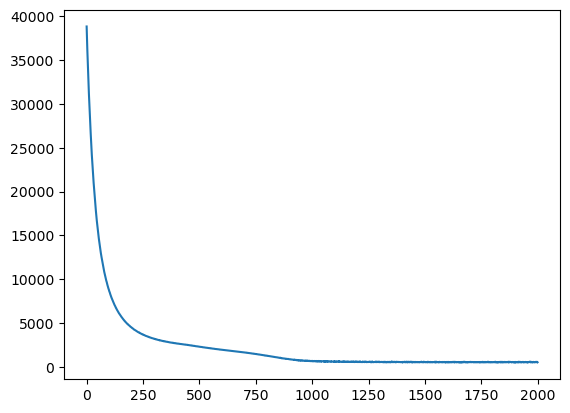

In [13]:
plt.plot(losses)

In [14]:
model.gp.kernel.lengthscale

Parameter containing:
tensor([[[2.8820]],

        [[1.5870]],

        [[0.8550]]], requires_grad=True)

In [15]:
model.cpu()
X_test= torch.linspace(-30, 30, 1000)[:, None]
qF, qU, pU = model.gp(X_test)

distances: torch.Size([1000, 300])
Indexes shape:  torch.Size([1000, 5])
Kxz: torch.Size([3000, 300])
kzz_inv: torch.Size([3000, 5, 5])
indexes: torch.Size([1000, 5])
Expanded shape torch.Size([3000, 5])


In [16]:
qF.scale

tensor([[0.6236, 0.6218, 0.6199,  ..., 0.6229, 0.6246, 0.6262],
        [1.2958, 1.2955, 1.2952,  ..., 1.2955, 1.2958, 1.2960],
        [1.9554, 1.9554, 1.9554,  ..., 1.9554, 1.9554, 1.9554]],
       grad_fn=<PowBackward0>)

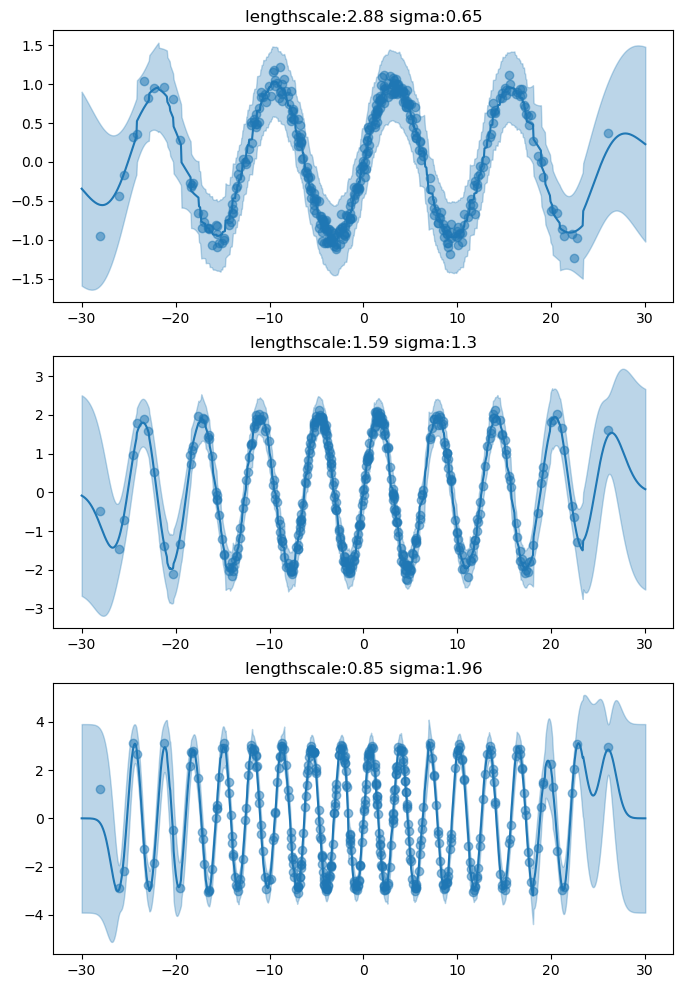

In [17]:
plt.figure(figsize=(8, 12))
for i in range(3):
  plt.subplot(3, 1, i+1)
  mean = qF.mean.detach().cpu().numpy()[i]
  sd = qF.scale.detach().cpu().numpy()[i]
  plt.plot(X_test, mean)
  plt.scatter(X, Y[i], alpha=0.5)
  plt.gca().fill_between(
            X_test[:, 0],  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd),
            (mean + 2.0 * sd),
            color="C0",
            alpha=0.3,
        )
  plt.title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[i].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[i].item(), 2)))